## Project: Vehicle Detection in video frame
---

The solution has been prepared in accordance to the rubrics defined [here](https://review.udacity.com/#!/rubrics/513/view).

### Step 1: Initialize the common libraries

In [1]:
import numpy as np
import cv2

import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import pickle
import time

# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn import tree

from collections import deque

#Visualisation
%matplotlib inline
from tqdm import tqdm_notebook

### Step 2: Load training data

In [2]:
vehicle_images = glob.glob('training_data/vehicles/*/*.png')
nonvehicle_images = glob.glob('training_data/non-vehicles/*/*.png')
print("No. of vehicle images: " + str(len(vehicle_images)), "\nNo. of non-vehicle images: " + str(len(nonvehicle_images)))

No. of vehicle images: 8792 
No. of non-vehicle images: 8968


### Step 3: Visualize dataset

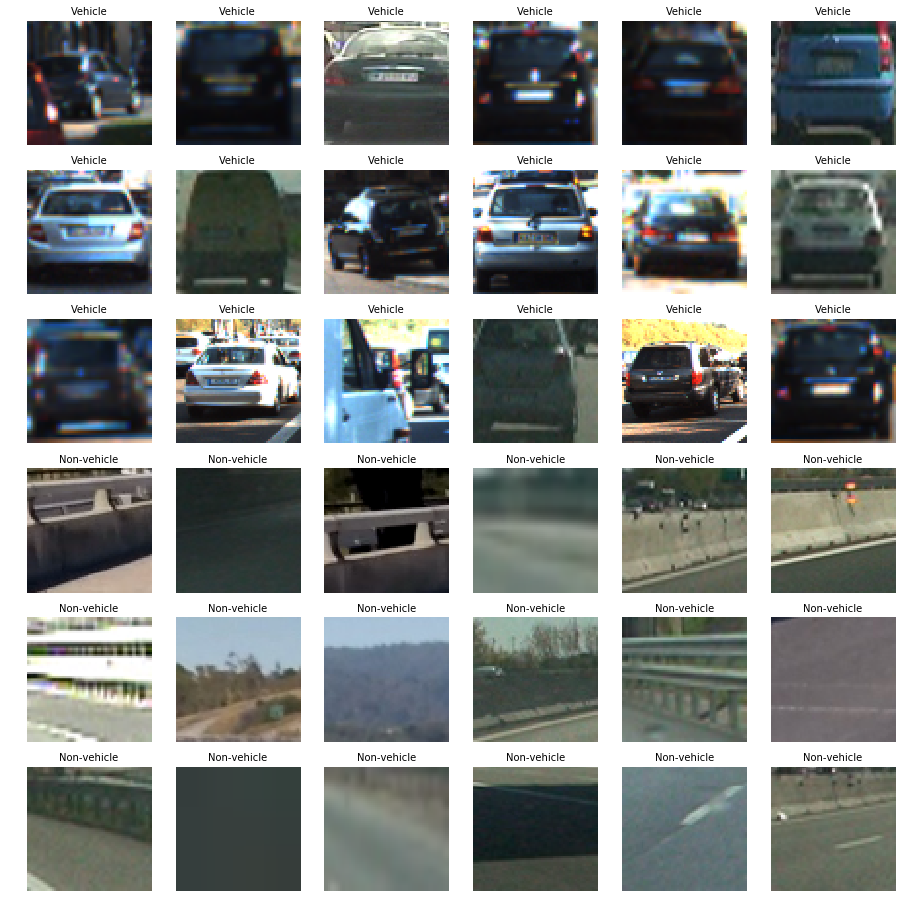

In [3]:
fig, axis = plt.subplots(6,6, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()

for i in np.arange(18):
    img = cv2.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('Vehicle', fontsize=10)
    axis[i].imshow(img)
for i in np.arange(18,36):
    img = cv2.imread(nonvehicle_images[np.random.randint(0,len(nonvehicle_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('Non-vehicle', fontsize=10)
    axis[i].imshow(img)

### Step 4: Helper functions for HOG, spatial binning and colour histogram

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm_notebook(imgs, desc="Loading model"):
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Step 5: Showcasing different colour channels

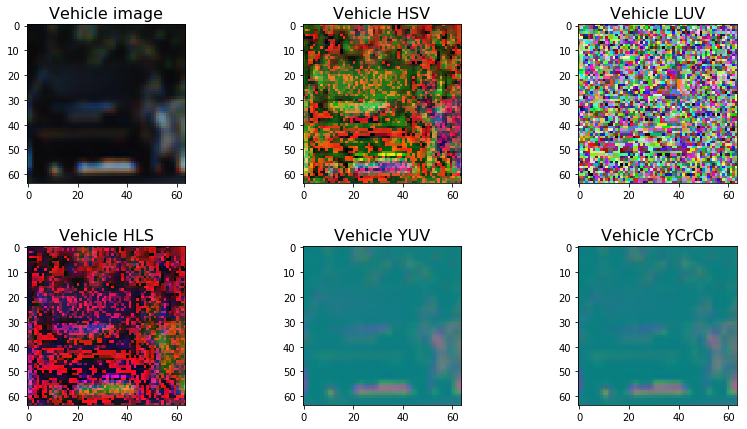

In [5]:
vehicle_img = mpimg.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
vehicle_img_HSV = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2HSV)
vehicle_img_LUV = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2LUV)
vehicle_img_HLS = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2HLS)
vehicle_img_YUV = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2YUV)
vehicle_img_YCrCb = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2YCrCb)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle image', fontsize=16)
ax2.imshow(vehicle_img_HSV)
ax2.set_title('Vehicle HSV', fontsize=16)
ax3.imshow(vehicle_img_LUV)
ax3.set_title('Vehicle LUV', fontsize=16)

ax4.imshow(vehicle_img_HLS)
ax4.set_title('Vehicle HLS', fontsize=16)
ax5.imshow(vehicle_img_YUV)
ax5.set_title('Vehicle YUV', fontsize=16)
ax6.imshow(vehicle_img_YCrCb)
ax6.set_title('Vehicle YCrCb', fontsize=16)

### Step 6: Extracted HOG features from images

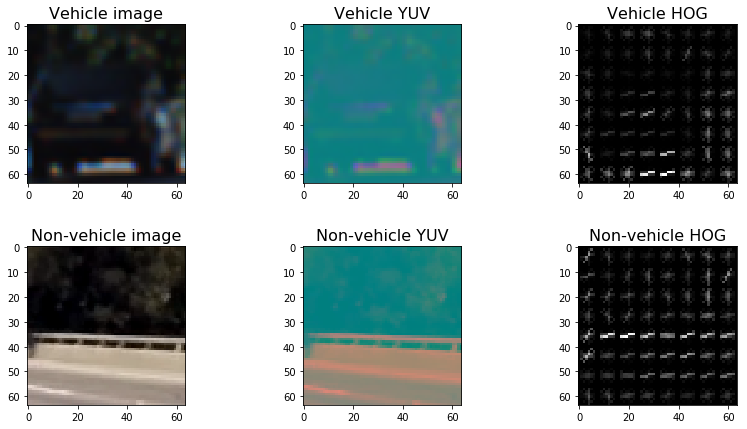

In [7]:
# Visual HOG features on image samples
#vehicle_img = mpimg.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
vehicle_img_YUV = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2YUV)
_, vehicle_dst = get_hog_features(vehicle_img_YUV[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
nonvehicle_img = mpimg.imread(nonvehicle_images[np.random.randint(0,len(nonvehicle_images))])
nonvehicle_img_YUV = cv2.cvtColor(nonvehicle_img, cv2.COLOR_RGB2YUV)
_, nonvehicle_dst = get_hog_features(nonvehicle_img_YUV[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle image', fontsize=16)
ax2.imshow(vehicle_img_YUV)
ax2.set_title('Vehicle YUV', fontsize=16)
ax3.imshow(vehicle_dst, cmap='gray')
ax3.set_title('Vehicle HOG', fontsize=16)

ax4.imshow(nonvehicle_img)
ax4.set_title('Non-vehicle image', fontsize=16)
ax5.imshow(nonvehicle_img_YUV)
ax5.set_title('Non-vehicle YUV', fontsize=16)
ax6.imshow(nonvehicle_dst, cmap='gray')
ax6.set_title('Non-vehicle HOG', fontsize=16)

### Step 7: Feature extraction

In [8]:
# Feature extraction parameters# Feature 
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
vehicle_features = extract_features(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
nonvehicle_features = extract_features(nonvehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))



65.69 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


### Step 8:  Training a classifier

In [9]:
print('Beginning classification')
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Beginning classification
1.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9769
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00822 Seconds to predict 10 labels with SVC


In [12]:
# Serializing data for re-use
import pickle
s = pickle.dumps(svc)
text_file = open("training_data/classifier.pkl", "wb")
text_file.write(s)
text_file.close()

### Step 9: Sliding window search concept

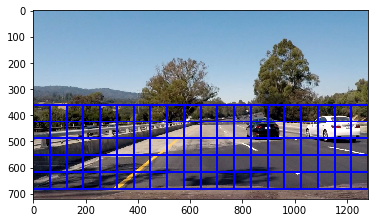

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Test on example images
test_img = mpimg.imread('test_images/test4.jpg')
windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[test_img.shape[0]//2, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Step 10: Finding cars in an image with scaled windows search and draw the rectangles

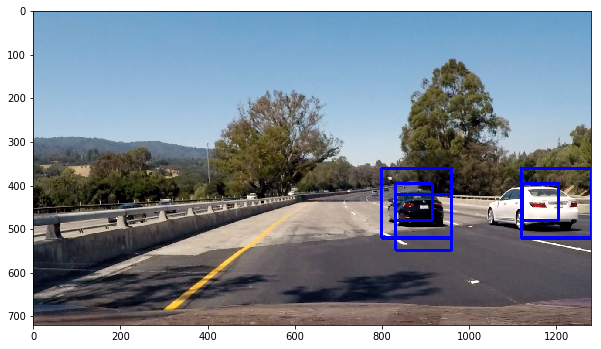

In [51]:
# Initializing the classifier and the tarining parameters (If you want to test quicktly, Run Step1 and Step 4 as well)
text_file = open("training_data/classifier.pkl", "rb")
s = text_file.read()
svc = pickle.loads(s)
text_file.close()

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

def find_cars_scaled_window(image, svc, orient, pix_per_cell, cell_per_block):
    bboxes = []
    
    
    
    height = image.shape[0]//2
    start = image.shape[0]//2
      
    ystart = start
    ystop = start + height//3
    
    bboxes.append(find_cars(image, ystart, ystop, 1.0, 'YUV', 
                           'ALL', svc, None, orient, pix_per_cell, 
                           cell_per_block, None, None))
    
    ystart = start + height//10
    ystop = start + 3*height//4
    bboxes.append(find_cars(image, ystart, ystop, 1.3, 'YUV', 
                           'ALL', svc, None, orient, pix_per_cell, 
                           cell_per_block, None, None))
    
    ystart = start + height//6
    ystop = start + 3*height//4
    bboxes.append(find_cars(image, ystart, ystop, 2, 'YUV', 
                           'ALL', svc, None, orient, pix_per_cell, 
                           cell_per_block, None, None))
    
    ystart = start
    ystop = start + height
    bboxes.append(find_cars(image, ystart, ystop, 2.5, 'YUV', 
                           'ALL', svc, None, orient, pix_per_cell, 
                           cell_per_block, None, None))

    return bboxes

# Test on example images
test_img = mpimg.imread('test_images/test4.jpg')

orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
bboxes = find_cars_scaled_window(test_img, svc, orient, pix_per_cell, cell_per_block)

bboxes = [item for sublist in bboxes for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Step 11: Draw bounding boxes for labels

2 cars found


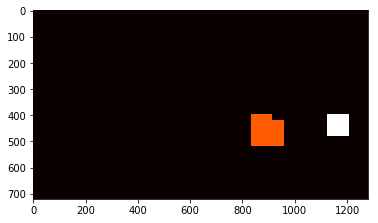

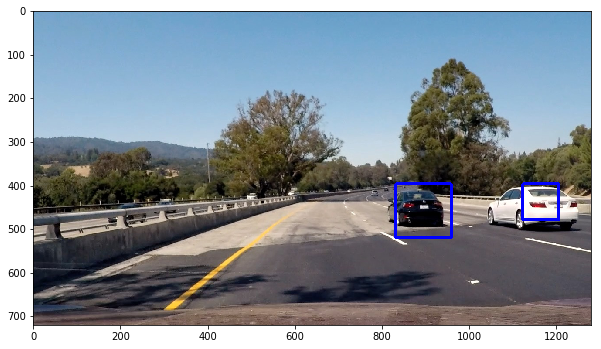

In [52]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

heat = np.zeros_like(test_img_rects[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes)

# Apply threshold to help remove false positives
threshold = 1
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap, structure=np.ones((3, 3)))
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='hot')
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Step 12: Processing a frame and testing on the test pipeline

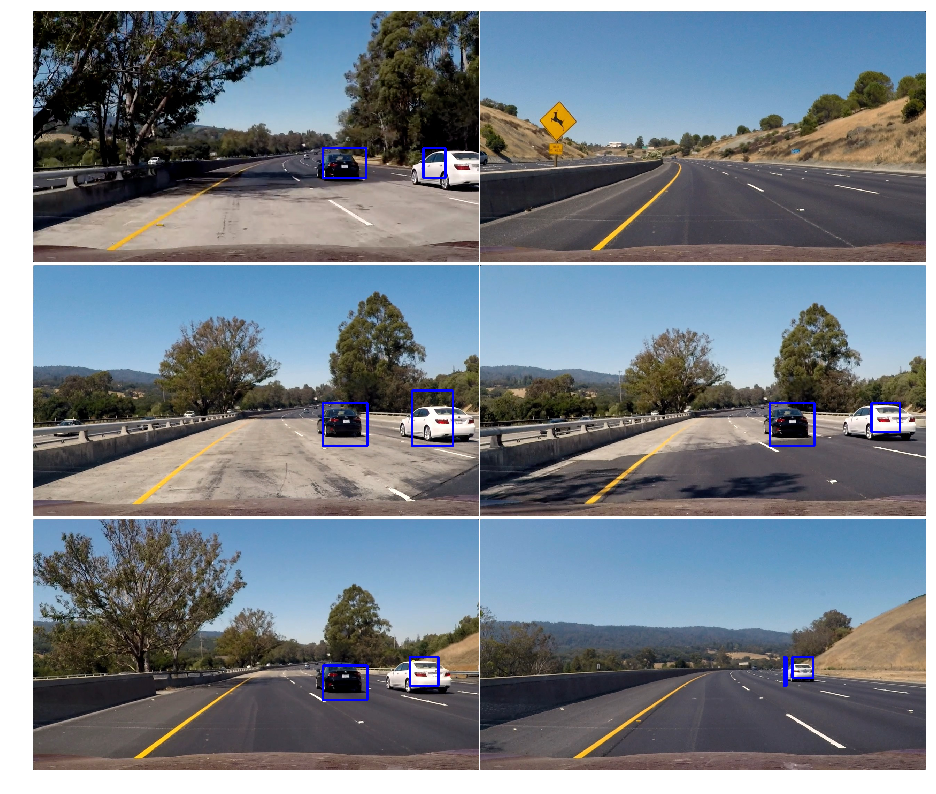

In [47]:
def process_frame(img):
    bboxes = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    
    bboxes = find_cars_scaled_window(img, svc, orient, pix_per_cell, cell_per_block)
    bboxes = [item for sublist in bboxes for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, bboxes)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img




test_images  = glob.glob('test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Step 13: Run test video through the above pipeline

In [48]:
test_out_file = 'videos/test_video_out.mp4'
clip_test = VideoFileClip('videos/test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video videos/test_video_out.mp4
[MoviePy] Writing video videos/test_video_out.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/test_video_out.mp4 

CPU times: user 11.4 s, sys: 436 ms, total: 11.8 s
Wall time: 11.9 s


### Step 14: Pipleline processing for video frames

In [53]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 5:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-5:]

In [ ]:
det = Vehicle_Detect()

proj_out_file = 'videos/project_video_out.mp4'
clip_proj = VideoFileClip('videos/project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video videos/project_video_out.mp4
[MoviePy] Writing video videos/project_video_out.mp4


 78%|███████▊  | 981/1261 [04:34<01:17,  3.62it/s]